In [3]:
from geoband.API import *
from geopandas.tools import sjoin


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import json
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString

import pydeck as pdk
import shapefile
import os
import re
import matplotlib 
matplotlib.font_manager._rebuild()
import seaborn as sns

import mapboxgl
from mapboxgl.viz import *
from mapboxgl.utils import create_color_stops

from matplotlib import font_manager, rc
import platform

import requests; from urllib.parse import urlparse
import warnings
warnings.filterwarnings("ignore")

from geoband.API import *
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import geopandas as gpd
import pandas as pd
import json
from pandas import json_normalize
import pandas as pd
import folium
from folium.plugins import MarkerCluster
from geoband.API import *
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
from geopandas import GeoDataFrame
# GetCompasData로 주피터 노트북 경로에 파일 저장
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, LineString
from fiona.crs import from_string
from pandas import json_normalize

from geoband.API import *
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import geopandas as gpd
import pandas as pd
import json
from pandas import json_normalize
import pandas as pd
import folium
from folium.plugins import MarkerCluster
from geoband.API import *
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
from geopandas import GeoDataFrame
# GetCompasData로 주피터 노트북 경로에 파일 저장
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, LineString
from fiona.crs import from_string

%matplotlib inline

import matplotlib.pyplot as plt
from libpysal.weights.contiguity import Queen
from libpysal import examples
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import splot

from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.rc('font', family='NanumBarunGothic') #한글 폰트 지정?

/opt/app-root/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## 표제부 데이터 처리하기

In [4]:
# 수원시 격자정보

suwon_112_grid = gpd.read_file('2.수원시_112신고(격자별 신고횟수).geojson').drop(["rep_cnt"],axis=1)

#suwon_building = pd.read_excel('26.수원시_건축물대장(표제부).xlsx')
suwon_building = pd.read_csv("26.수원시_건축물대장(표제부)_위경도매핑.csv")[["regstr_gb_cd_nm","regstr_kind_nm",
                                                             "fmly_cnt","hhld_cnt","arch_area","plat_area","plat_plc",
                                                             "main_purps_cd","main_purps_cd_nm",
                                                             "lon","lat"]]
suwon_building.columns = ["대장구분코드명","대장종류코드명","세대수","가구수","건축면적","대지면적","대지위치",
                          "주용도코드","주용도코드명",
                         "lon","lat"]

In [5]:
df = suwon_building.copy()
if "geometry" in df.columns:
    pass
else:
    epsg4326 = from_string("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
    df['Point'] = df.apply(lambda x : Point([x['lon'], x['lat']]), axis=1)
    df = gpd.GeoDataFrame(df, geometry='Point', crs = epsg4326)

In [18]:
gid_result_lst = [] # 격자별 시설 개수

df["cnt"] = 1
주용도코드명_lst = ["제1종근린생활시설","제2종근린생활시설","문화 및 집회시설","공장","업무시설","교육연구시설","교육연구및복지시설"]

for 코드명 in 주용도코드명_lst:
    df_code = df[df["주용도코드명"] == 코드명]
    gid_result = gpd.sjoin(df_code,suwon_112_grid,how='left', op="intersects")
    gid_result_groupby = gid_result.groupby(["gid"]).agg({"cnt":"sum"}).reset_index().rename(columns={"cnt":코드명+"_격자별개수"})
    gid_result_lst.append(gid_result_groupby)
    
    # 시설별 위경도 정보
    gid_result[["주용도코드명","lon","lat"]].to_csv("수원시_"+코드명+"_현황.csv",encoding="utf-8-sig",index=False)

result = suwon_112_grid
for j in gid_result_lst:
    result = pd.merge(result,j,on="gid",how="left").fillna(0)
result.drop("geometry",axis=1,inplace=True)

result["근린생활시설_격자별개수"] = result["제1종근린생활시설_격자별개수"] + result["제2종근린생활시설_격자별개수"]
result["교육연구시설_격자별개수"] = result["교육연구시설_격자별개수"] + result["교육연구및복지시설_격자별개수"]

In [9]:
result.to_csv("수원시_표제부시설현황.csv",encoding="utf-8-sig",index=False)

## 상권데이터 처리하기
- 유흥시설 = 유흥주점 + 위락시설
- 숙박시설
- 체육시설

In [3]:
import pandas as pd
suwon_commercial_area = pd.read_excel('25.수원시_상권(업종)현황.xlsx')[["business_nm","com_lc_cd","com_lc_nm",
                                                               "com_mc_cd","com_mc_nm","com_sc_cd","com_sc_nm","ksic_cd","ksic_nm",
                                                               "sido_nm","sgg_cd","sgg_nm","adb_emd_cd",
                                                               "adb_emd_nm","lon","lat"]]

suwon_commercial_area.columns = ["상호명","상권업종대분류코드","상권업종대분류명","상권업종중분류코드","상권업종중분류명",
                                 "상권업종소분류코드","상권업종소분류명","표준산업분류코드","표준산업분류명","시도명",
                                 "시군구코드","시군구명","행정동코드","행정동명","lon","lat"]

suwon_commercial_area_accomo = suwon_commercial_area[suwon_commercial_area["상권업종대분류명"] == "숙박"]
# 숙박시설정보만

In [4]:
suwon_commercial_area_play = suwon_commercial_area[suwon_commercial_area["상권업종대분류명"] == "관광/여가/오락"]
# 유흥시설 정보만
suwon_commercial_area_play["상권업종소분류명"].value_counts()

# 관광/여가/오락 시설 중에서 (+) : "단전호흡","기원","체형미교실","지압원","실내야구연습장","낚시터","실외야구연습장","롤러스케이트장",
# "롤러스케이트장","오락용사격장"
plus = ["단전호흡","기원","체형미교실","지압원","실내야구연습장","낚시터","실외야구연습장","롤러스케이트장","오락용사격장"]
minus = ["노래방","인터넷PC방","당구장","스포츠마사지","안마시술소","게임룸","기타오락관련산업","나이트클럽",
         "무도유흥주점-종합","전자오락실","비디오감상실","무도장","극장식유흥주점"]

# 관광/여가/오락 시설 중에서 (-) : "노래방","인터넷PC방","당구장","스포츠마사지","안마시술소","게임룸","기타오락관련산업","나이트클럽",
# "무도유흥주점-종합","전자오락실","비디오감상실","무도장","극장식유흥주점"

plus_lst = []
for i in plus:
    plus_lst.append(suwon_commercial_area_play[suwon_commercial_area_play["상권업종소분류명"] == i])
    
plus_lst.append(suwon_commercial_area[suwon_commercial_area["상권업종중분류명"] == "스포츠"])
# 스포츠 시설 추가하기
    
minus_lst = []
for i in minus:
    minus_lst.append(suwon_commercial_area_play[suwon_commercial_area_play["상권업종소분류명"] == i])
# 위락시설 추가하기
suwon_commercial_area_play = pd.concat(minus_lst)
# 위락시설

suwon_commercial_area_alcohol = suwon_commercial_area[suwon_commercial_area["상권업종중분류명"] == "유흥주점"]

minus_lst.append(suwon_commercial_area[suwon_commercial_area["상권업종중분류명"] == "유흥주점"])
# 음식 업소 정보 - 중분류에 '유흥주점' 만 가져오기
# 해당 격자내 총 음식점 수 중에서 유흥주점의 수

suwon_commercial_area_play_sport = pd.concat(plus_lst)
# 체육시설

suwon_commercial_area_alcohol_play = pd.concat(minus_lst)
# 유흥주점 + 오락시설 = 유흥시설

In [5]:
suwon_commercial_area_accomo.to_csv("수원시_숙박시설현황.csv",encoding="utf-8-sig",index=False)
suwon_commercial_area_play_sport.to_csv("수원시_체육시설현황.csv",encoding="utf-8-sig",index=False)
suwon_commercial_area_alcohol_play.to_csv("수원시_유흥시설현황.csv",encoding="utf-8-sig",index=False)
suwon_commercial_area_play.to_csv("수원시_위락시설현황.csv",encoding="utf-8-sig",index=False)
suwon_commercial_area_alcohol.to_csv("수원시_유흥주점현황.csv",encoding="utf-8-sig",index=False)
suwon_commercial_area.to_csv("수원시_상업시설현황.csv",encoding="utf-8-sig",index=False)

# 사고다발지역 데이터 처리하기
- 무단횡단
- 스쿨존
- 보행어린이
- 보행고령자
- 자전거

In [ ]:
school_risk_area = pd.read_csv("스쿨존_사고다발.csv",encoding="cp949")
old_risk_area = pd.read_csv("고령_사고다발.csv",encoding="cp949")
bic_risk_area = pd.read_csv("자전거_사고다발.csv",encoding="cp949")
jay_risk_area = pd.read_csv("무단횡단_사고다발.csv",encoding="cp949")
child_risk_area = pd.read_csv("보행어린이_사고다발.csv",encoding="cp949")

사고 유형 컬럼 추가하기

In [ ]:
school_risk_area["사고유형"] = "스쿨존내어린이사고"
old_risk_area["사고유형"] = "보행고령자사고"
bic_risk_area["사고유형"] = "자전거사고"
jay_risk_area["사고유형"] = "보행자무단횡단사고"
child_risk_area["사고유형"] = "보행어린이사고"

모든 사고 유형 합쳐주기

In [ ]:
all_risk_area = pd.concat([school_risk_area,old_risk_area,bic_risk_area,jay_risk_area,child_risk_area],
                         axis=0).reset_index(drop=True)

#### string_to_polygon
- 주어진 df
- polygon 정보가 들어있는 geo_col이 문자열 형식일 때 polygon 형태로 변경해주기

In [ ]:
def string_to_polygon(df,geo_col):
    data = df.copy()
    data["geometry"] = data[geo_col].apply(lambda x : Polygon(eval(x)["coordinates"][0]))
    data.drop(geo_col,axis=1,inplace=True)
    return data

In [ ]:
all_risk_area_geo = string_to_polygon(all_risk_area,"다발지역폴리곤")
all_risk_area_geo = gpd.GeoDataFrame(all_risk_area_geo)

# 2020년 사고다발 데이터만 가져오기
all_risk_area_geo["사고다발지ID"] = all_risk_area_geo["사고다발지ID"].astype(str)
all_risk_area_geo = all_risk_area_geo[all_risk_area_geo["사고다발지ID"].str[:4] == "2020"]

GeoJSON으로 내보내기

In [ ]:
all_risk_area_geo.to_file("사고유형별_사고다발지역.geojson",driver="GeoJSON")

In [55]:
subway = pd.read_csv("전국도시철도역사정보표준데이터.csv",encoding="cp949")[["역사명","역사도로명주소","역경도","역위도"]]
subway.columns = ["기관명","기관주소","lon","lat"]

subway = subway[(subway["기관주소"].str.contains("서울")) | (subway["기관주소"].str.contains("수원"))]
# 서울 수원 데이터만 추출

others_subway = subway.drop_duplicates(["기관주소"],keep="first").reset_index(drop=True)

In [56]:
others_subway.to_csv("4개시도_지하철역.csv",encoding="utf-8-sig")

### 전국 초중고 데이터

In [73]:
others_school = pd.read_csv("한국교원대학교_초중등학교위치.csv",encoding="cp949")[["학교명","학교급구분","소재지도로명주소","경도","위도"]]
others_school = others_school[(others_school["소재지도로명주소"].str.contains("창원")) 
                              | (others_school["소재지도로명주소"].str.contains("진주"))
                              | (others_school["소재지도로명주소"].str.contains("서울"))
                              | (others_school["소재지도로명주소"].str.contains("수원"))]

others_school.columns = ["학교명","학교급구분","소재지도로명주소","lon","lat"]

In [70]:
others_school.to_csv("4개시도_초중고.csv",encoding="utf-8-sig")

### 전국 어린이집

In [76]:
어린이집_창원 = pd.read_excel("어린이집기본정보조회_창원.xls")
어린이집_수원 = pd.read_excel("어린이집기본정보조회_수원.xls")
어린이집_진주 = pd.read_excel("어린이집기본정보조회_진주.xls")
어린이집_서울 = pd.read_excel("어린이집기본정보조회_서울.xls")

others_baby = pd.concat([어린이집_창원,어린이집_수원,어린이집_진주,어린이집_서울])[["어린이집명","운영현황","주소","경도","위도"]]

others_baby = others_baby[(others_baby["운영현황"] == "정상") | (others_baby["운영현황"] == "재개")].reset_index(drop=True)
others_baby.columns = ["어린이집명","운영현황","주소","lon","lat"]
# 정상 운영되는 곳만

In [89]:
others_baby.to_csv("4개시도_어린이집.csv",encoding="utf-8-sig")

# 접근성
- 주차장 접근성
- 경찰서 접근성
- 소방서 접근성

수원시 권선구   41113
수원시 장안구   41111
수원시 영통구   41117
수원시 팔달구   41115

In [23]:
police_near = gpd.read_file("385.1 경찰서 접근성.shp",encoding="utf-8")
parking_near = gpd.read_file("334.1 주차장 접근성.shp",encoding="utf-8")
fire_near = gpd.read_file("387.1 소방서 접근성.shp",encoding="utf-8")
doc_near = gpd.read_file("275.1 의원 접근성.shp",encoding="utf-8")
hos_near = gpd.read_file("281.1 병원 접근성.shp",encoding="utf-8") 
med_near = gpd.read_file("299.1 약국 접근성.shp",encoding="utf-8") 
kinder_near = gpd.read_file("218.1 유치원 접근성.shp",encoding="utf-8") 
baby_near = gpd.read_file("214.1 어린이집 접근성.shp",encoding="utf-8") 
ele_near = gpd.read_file("222.1 초등학교 접근성.shp",encoding="utf-8") ##
lib_near = gpd.read_file("227.1 도서관 접근성.shp",encoding="utf-8") 
cul_near = gpd.read_file("239.1 공연문화시설 접근성.shp",encoding="utf-8")
sport1_near = gpd.read_file("52.1.생활체육시설접근성.shp",encoding="utf-8") 
sport2_near = gpd.read_file("207.1 공공체육시설 접근성.shp",encoding="utf-8") ##
park1_near = gpd.read_file("203.1 주제공원 접근성.shp",encoding="utf-8")
park2_near = gpd.read_file("199.1 생활권공원 접근성.shp",encoding="utf-8")

In [103]:
for j in [ police_near,parking_near,fire_near,doc_near,hos_near,med_near,kinder_near,baby_near,ele_near,
 lib_near,cul_near,sport1_near,sport2_near,park1_near,park2_near ]:
    j.columns = [i.lower() for i in j.columns]
# 전부다 소문자로 열 변경

### 접근성 데이터에서 500 격자 추출하기

In [28]:
suwon_police_near = police_near[(police_near["sgg_cd"] == 41111) | (police_near["sgg_cd"] == 41113) |
                               (police_near["sgg_cd"] == 41115) | (police_near["sgg_cd"] == 41117)]
# 수원시 데이터만 추출

suwon_police_near = suwon_police_near.to_crs(epsg="4326")
# 좌표계 4326으로 변환

suwon_112_grid = gpd.read_file('2.수원시_112신고(격자별 신고횟수).geojson').drop(["rep_cnt"],axis=1).rename(columns={"gid":"gid_250"})
# 수원시 격자정보
suwon_112_grid.head(3)

,gid_250,geometry
0,다사49aa19ab,"MULTIPOLYGON (((126.92477 37.27077, 126.92475 ..."
1,다사49aa19ba,"MULTIPOLYGON (((126.92475 37.27302, 126.92473 ..."
2,다사49aa20aa,"MULTIPOLYGON (((126.92472 37.27753, 126.92470 ..."


In [43]:
suwon_police_near["gid_250"] = suwon_police_near["gid"].apply(lambda x : x[:5]+"a"+x[5:8]+"a")
suwon_police_near["gid_250"] = suwon_police_near["gid"].apply(lambda x : x[:5]+"b"+x[5:8]+"a")
suwon_police_near["gid_250"] = suwon_police_near["gid"].apply(lambda x : x[:5]+"b"+x[5:8]+"b")
suwon_police_near["gid_250"] = suwon_police_near["gid"].apply(lambda x : x[:5]+"a"+x[5:8]+"b")
# 500격자에 할당되는 250격자 매핑해주기

sjoin = pd.merge(suwon_police_near,suwon_112_grid["gid_250"],on="gid_250",how="inner")[["gid","geometry","gid_250"]]
sjoin.head(4)

,gid,geometry,gid_250
0,다사49b18a,"POLYGON ((126.93049 37.25953, 126.93046 37.264...",다사49ba18ab
1,다사49b18b,"POLYGON ((126.93046 37.26403, 126.93042 37.268...",다사49ba18bb
2,다사49b19a,"POLYGON ((126.93042 37.26854, 126.93039 37.273...",다사49ba19ab
3,다사49b19b,"POLYGON ((126.93039 37.27305, 126.93036 37.277...",다사49ba19bb


In [45]:
sjoin.to_file("수원시_500격자.geojson",driver="GeoJSON")

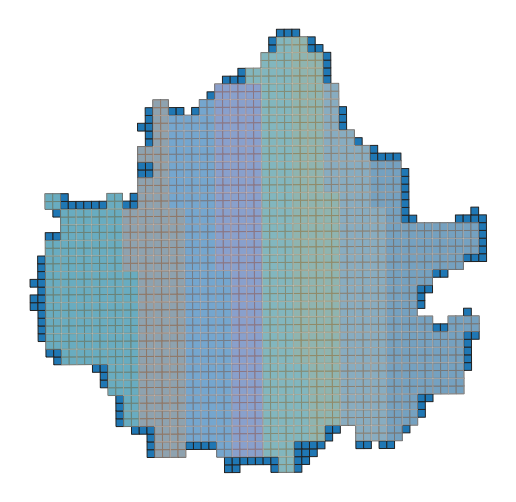

In [40]:
f, ax = plt.subplots(1, figsize=(9, 9))
suwon_112_grid.plot(linewidth=1,ax=ax, edgecolor = '#232323', legend=True)
#test1.plot(linewidth=1,ax=ax,color="red" ,edgecolor = '#232323', legend=True)
sjoin.plot(linewidth=0.5,alpha=0.5,cmap="Pastel2",ax=ax, edgecolor = 'gainsboro', legend=True)
# sjoin은 수원시의 500격자
ax.set_axis_off()

250격자에 매핑되는 500격자 찾기

In [40]:
suwon_grid_250_500 = gpd.read_file('2.수원시_112신고(격자별 신고횟수).geojson').drop(["rep_cnt"],axis=1).rename(columns={"gid":"gid_250"})
# 수원시 격자정보
suwon_grid_250_500.head(3)
suwon_grid_250_500["gid_500"] = suwon_grid_250_500["gid_250"].apply(lambda x : x[:5]+x[6:9])
suwon_grid_250_500 = suwon_grid_250_500.drop("geometry",axis=1)
suwon_grid_250_500.to_csv("250격자_500격자_매핑.csv",encoding="utf-8-sig",index=False)

In [41]:
suwon_grid_250_500

,gid_250,gid_500
0,다사49aa19ab,다사49a19a
1,다사49aa19ba,다사49a19b
2,다사49aa20aa,다사49a20a
3,다사49ab18ab,다사49a18a
4,다사49ab18ba,다사49a18b
...,...,...
2085,다사63ba21aa,다사63b21a
2086,다사63ba21ab,다사63b21a
2087,다사63ba21ba,다사63b21b
2088,다사63ba21bb,다사63b21b


### 접근성 데이터 가공하기
- 수원 500격자에 연결하기 위해

In [20]:
suwon_112_grid_500 = gpd.read_file('수원시_500격자.geojson')
# 수원시 500 격자정보
suwon_112_grid_500

,gid,gid_250,geometry
0,다사49b18a,다사49ba18ab,"POLYGON ((126.93049 37.25953, 126.93046 37.264..."
1,다사49b18b,다사49ba18bb,"POLYGON ((126.93046 37.26403, 126.93042 37.268..."
2,다사49b19a,다사49ba19ab,"POLYGON ((126.93042 37.26854, 126.93039 37.273..."
3,다사49b19b,다사49ba19bb,"POLYGON ((126.93039 37.27305, 126.93036 37.277..."
4,다사49b20a,다사49ba20ab,"POLYGON ((126.93036 37.27755, 126.93032 37.282..."
...,...,...,...
479,다사62b21a,다사62ba21ab,"POLYGON ((127.07694 37.28718, 127.07692 37.291..."
480,다사62b21b,다사62ba21bb,"POLYGON ((127.07692 37.29169, 127.07689 37.296..."
481,다사63a18b,다사63aa18bb,"POLYGON ((127.08271 37.26467, 127.08268 37.269..."
482,다사63a21a,다사63aa21ab,"POLYGON ((127.08258 37.28720, 127.08256 37.291..."


In [101]:
suwon_112_grid_500 = gpd.read_file('수원시_500격자.geojson')
# 수원시 500 격자정보

def get_접근성_data(data,col,suwon_112_grid_500):
    #suwon_data = data[(data["sgg_cd"] == 41111) | (data["sgg_cd"] == 41113) |
    #                              (data["sgg_cd"] == 41115) | (data["sgg_cd"] == 41117)]
    # 수원시 데이터만 추출 -> 코드 없는 곳 존재

    suwon_data = data.to_crs(epsg="4326")[["gid","value"]].rename(columns={"value":col})
    # 좌표계 4326으로 변환

    suwon_data = pd.merge(suwon_data,suwon_112_grid_500,on="gid")
    # 수원시 500 격자와 250 격자 연결
    return suwon_data

In [105]:
suwon_parking_near = get_접근성_data(parking_near,"주차장접근성",suwon_112_grid_500)
suwon_police_near = get_접근성_data(police_near,"경찰서접근성",suwon_112_grid_500)
suwon_fire_near = get_접근성_data(fire_near,"소방서접근성",suwon_112_grid_500)

suwon_doc_near = get_접근성_data(doc_near,"의원접근성",suwon_112_grid_500)
suwon_hos_near = get_접근성_data(hos_near,"병원접근성",suwon_112_grid_500)
suwon_med_near = get_접근성_data(med_near,"약국접근성",suwon_112_grid_500)
suwon_kinder_near = get_접근성_data(kinder_near,"유치원접근성",suwon_112_grid_500)
suwon_baby_near = get_접근성_data(baby_near,"어린이집접근성",suwon_112_grid_500) #
suwon_ele_near = get_접근성_data(ele_near,"초등학교접근성",suwon_112_grid_500) ##
suwon_lib_near = get_접근성_data(lib_near,"도서관접근성",suwon_112_grid_500) ##
suwon_cul_near = get_접근성_data(cul_near,"공연문화시설접근성",suwon_112_grid_500)
suwon_sport1_near = get_접근성_data(sport1_near,"생활체육시설접근성",suwon_112_grid_500)
suwon_sport2_near = get_접근성_data(sport2_near,"공공체육시설접근성",suwon_112_grid_500) ## 
suwon_park1_near = get_접근성_data(park1_near,"주제공원접근성",suwon_112_grid_500) 
suwon_park2_near = get_접근성_data(park2_near,"생활권공원접근성",suwon_112_grid_500)

In [55]:
data = baby_near
suwon_data = data[(data["sgg_cd"] == 41111) | (data["sgg_cd"] == 41113) |
                                   (data["sgg_cd"] == 41115) | (data["sgg_cd"] == 41117)]

In [106]:
result = suwon_112_grid_500
for i in [suwon_parking_near,suwon_police_near,suwon_fire_near,suwon_doc_near,suwon_hos_near,suwon_med_near,suwon_kinder_near,
         suwon_baby_near,suwon_ele_near,suwon_lib_near,suwon_cul_near,suwon_sport1_near,suwon_sport2_near,suwon_park1_near,suwon_park2_near]:
    
    result = pd.merge(result,i.drop("geometry",axis=1),on=["gid","gid_250"],how="left")
    # 결과값 연결

In [107]:
result["공원접근성"] = result["주제공원접근성"] + result["생활권공원접근성"]
result["체육시설접근성"] = result["생활체육시설접근성"] + result["공공체육시설접근성"]
result["병의원접근성"] = result["병원접근성"] + result["의원접근성"]

In [108]:
result.isnull().sum()

gid          0
gid_250      0
geometry     0
주차장접근성       0
경찰서접근성       0
소방서접근성       0
의원접근성        0
병원접근성        0
약국접근성        0
유치원접근성       0
어린이집접근성      0
초등학교접근성      0
도서관접근성       0
공연문화시설접근성    0
생활체육시설접근성    0
공공체육시설접근성    0
주제공원접근성      0
생활권공원접근성     0
공원접근성        0
체육시설접근성      0
병의원접근성       0
dtype: int64

In [112]:
result.to_file("500격자데이터.geojson",driver="GeoJSON")

In [115]:
result

,gid,gid_250,geometry,주차장접근성,경찰서접근성,소방서접근성,의원접근성,병원접근성,약국접근성,유치원접근성,...,초등학교접근성,도서관접근성,공연문화시설접근성,생활체육시설접근성,공공체육시설접근성,주제공원접근성,생활권공원접근성,공원접근성,체육시설접근성,병의원접근성
0,다사49b18a,다사49ba18ab,"POLYGON ((126.93049 37.25953, 126.93046 37.264...",2.437,3.154,5.15938,2.57404,3.062490,2.581407,2.329,...,2.209,2.025,8.436,13.546174,5.411,2.142,1.864,4.006,18.957174,5.636530
1,다사49b18b,다사49ba18bb,"POLYGON ((126.93046 37.26403, 126.93042 37.268...",2.229,2.498,5.41407,1.45173,2.854181,1.459098,1.609,...,1.675,0.903,8.693,12.423866,5.666,1.236,1.122,2.358,18.089866,4.305911
2,다사49b19a,다사49ba19ab,"POLYGON ((126.93042 37.26854, 126.93039 37.273...",2.582,2.376,5.51262,1.15628,2.581755,1.163645,0.821,...,0.821,0.799,8.493,11.875413,5.225,1.061,1.244,2.305,17.100413,3.738035
3,다사49b19b,다사49ba19bb,"POLYGON ((126.93039 37.27305, 126.93036 37.277...",2.911,2.168,5.84168,1.14445,2.373819,0.697984,0.480,...,0.480,0.339,8.189,11.811477,5.281,1.390,0.725,2.115,17.092477,3.518269
4,다사49b20a,다사49ba20ab,"POLYGON ((126.93036 37.27755, 126.93032 37.282...",4.082,2.255,6.38357,2.06302,3.134391,2.063017,2.318,...,2.117,1.781,7.022,10.847048,5.565,2.149,1.963,4.112,16.412048,5.197411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,다사62b21a,다사62ba21ab,"POLYGON ((127.07694 37.28718, 127.07692 37.291...",2.036,3.641,5.23336,4.28150,4.041695,4.281500,3.961,...,3.961,3.387,5.316,16.492073,5.681,7.908,3.951,11.859,22.173073,8.323195
480,다사62b21b,다사62ba21bb,"POLYGON ((127.07692 37.29169, 127.07689 37.296...",0.902,2.162,3.61776,1.33753,1.958569,1.337527,1.142,...,1.142,0.331,3.950,13.436795,3.324,4.680,0.896,5.576,16.760795,3.296099
481,다사63a18b,다사63aa18bb,"POLYGON ((127.08271 37.26467, 127.08268 37.269...",2.265,2.508,3.72993,1.41730,1.555210,1.481683,0.992,...,0.992,1.405,3.519,17.911889,3.435,6.081,1.319,7.400,21.346889,2.972510
482,다사63a21a,다사63aa21ab,"POLYGON ((127.08258 37.28720, 127.08256 37.291...",1.224,2.830,4.42170,3.46984,3.230039,3.469844,3.149,...,3.149,2.575,4.504,15.680417,4.870,7.097,3.139,10.236,20.550417,6.699879
